In [139]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications import Xception
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Lambda
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [263]:
#The following code is an attempt to use a siamese neural network with transfer learning to classify if an image is a faulty screw
#Images of screws are located in two folders, one labeled as 'good' and another as 'not-good', meaning faulty screws.
#There are 50 'not-good' screws and 250 'good'.

#Augment the images in the "not-good" folder by flipping each image up, left, and then up and left. Giving 200 total 'not-good' images. 

path = 'screws/train/not-good/'

for img_name in os.listdir(path):
    
#Im using a mac, which creates these hidden copies of files starting with a ., so this if statement just avoids them
    if img_name[0] != '.':
        
#read each file name and flips image up, then saves new image
        img = cv2.imread(path + img_name)
        img_name = img_name[:-4]

        img_flip_ud = cv2.flip(img, 0)
        cv2.imwrite(path + img_name + 'up.png', img_flip_ud)
       
        #flips image left to right
        img_flip_lr = cv2.flip(img, 1)
        cv2.imwrite(path + img_name + 'lr.png', img_flip_lr)
       

        #flips image up and down and left to right
        img_flip_ud_lr = cv2.flip(img, -1)
        cv2.imwrite(path + img_name + 'udlr.png', img_flip_ud_lr)
        
#this creates 200 total images in the 'not-good class'

#To create 50 additional images to match the good class, the original 50 images are rotate 90 degrees
for img_name in os.listdir(path):
    if ((img_name[-5] != 'p' and img_name[-5] != 'r') and (img_name[0] != '.')):
        img = cv2.imread(path + img_name)
        img_rotate = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        img_name = img_name[:-4]
        cv2.imwrite(path + img_name + 'rotate.png', img_rotate)
        
        
        
        
        
        

In [306]:
#Set Parameters
epochs = 30
batch_size = 16
margin = 1

In [265]:
Image_Folder = "screws/train"
Class = ['good', 'not-good']

In [289]:
#Loading Images into a list for training

training_data = []
print("Loading Images")
IMG_SIZE = 224
def create_training_data(): 
    for class_name in Class:
        path = os.path.join(Image_Folder, class_name)

#converts class names into numbers
        class_num = Class.index(class_name)
    
        for img in os.listdir(path):
            try:
#Resizes image to 224 x224 from 1024 x 1024
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
#Stores all images and their classes in training data
create_training_data()

Loading Images


In [290]:
#shuffles all the data because currently its in order they are stored in by class
import random
random.shuffle(training_data)

In [291]:
#seperate data and labels

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)


In [292]:
#normalizes data to 0-1 by dividing by highest pixel number
X = [i / 255.0 for i in X]

X = np.asarray(X)
y = np.asarray(y)



In [319]:
print("Seperating data into train, test, validation sets" )

x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=14)

Seperating data into train, test, validation sets


In [320]:
# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

In [321]:

#70% train, 15% val, 15% test
x_train, x_val = x_train_val[:350], x_train_val[350:]
y_train, y_val = y_train_val[:350], y_train_val[350:]
del x_train_val, y_train_val

In [322]:
#Code for making image pairs and the basic underlying structure of the Siamese neural network from Keras Siamese neural network guide. 
#https://keras.io/examples/vision/siamese_contrastive/

print("Making image pairs" )
def make_pairs(x, y):

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

Making image pairs


In [323]:
#seperating the pairs so they can be fed seperatly to the two CNNs 
x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]


x_val_1 = pairs_val[:, 0] 
x_val_2 = pairs_val[:, 1]


x_test_1 = pairs_test[:, 0]  
x_test_2 = pairs_test[:, 1]

In [330]:
def euclidean_distance(vects):
    
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

#load VGG16 weights and freeze layers. 

vgg = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

vgg.trainable = False


# New model on top (3 channels)
input = keras.Input(shape=(224, 224, 3))

x = input

x = vgg(x, training=False)
x = tf.keras.layers.BatchNormalization()(input)


x = layers.Conv2D(8, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Dropout(0.2)(x) 

x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Dropout(0.3)(x) 

x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="relu")(x)

#input for two images
embedding_network = keras.Model(input, x)
image_1 = layers.Input((224, 224, 3))
image_2 = layers.Input((224, 224, 3))

#two CNN's created
CNN_1 = embedding_network(image_1)
CNN_2 = embedding_network(image_2)


CNN_merge = layers.Lambda(euclidean_distance)([CNN_1, CNN_2])
normalization = tf.keras.layers.BatchNormalization()(CNN_merge)
output_layer = layers.Dense(1, activation="sigmoid")(normalization)
siamese = keras.Model(inputs=[image_1, image_2], outputs=output_layer)

In [325]:
#contrastive loss 
def loss(margin=1):
 

    def contrastive_loss(y_true, y_pred):
  
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [331]:
optimizer = keras.optimizers.Adam(lr=0.001)
siamese.compile(loss=loss(margin=margin), optimizer="adam", metrics=["accuracy"])
siamese.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_26 (Functional)           (None, 10)           1308950     input_49[0][0]                   
                                                                 input_50[0][0]                   
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 1)            0           model_26[0][0]            

In [327]:
#make data into 3 color channels

x_train_1 = np.repeat(x_train_1[..., np.newaxis], 3, -1)
x_train_2 = np.repeat(x_train_2[..., np.newaxis], 3, -1)
x_val_1 = np.repeat(x_val_1[..., np.newaxis], 3, -1)
x_val_2 = np.repeat(x_val_2[..., np.newaxis], 3, -1)

In [332]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/30
44/44 [==============================] - 19s 405ms/step - loss: 0.2823 - accuracy: 0.4971 - val_loss: 0.2959 - val_accuracy: 0.5000
Epoch 2/30
44/44 [==============================] - 18s 410ms/step - loss: 0.2673 - accuracy: 0.5286 - val_loss: 0.2914 - val_accuracy: 0.5000
Epoch 3/30
44/44 [==============================] - 19s 426ms/step - loss: 0.2570 - accuracy: 0.5543 - val_loss: 0.2809 - val_accuracy: 0.5000
Epoch 4/30
44/44 [==============================] - 19s 439ms/step - loss: 0.2503 - accuracy: 0.5686 - val_loss: 0.2698 - val_accuracy: 0.5000
Epoch 5/30
44/44 [==============================] - 19s 429ms/step - loss: 0.2419 - accuracy: 0.6000 - val_loss: 0.2700 - val_accuracy: 0.4467
Epoch 6/30
44/44 [==============================] - 19s 427ms/step - loss: 0.2355 - accuracy: 0.6057 - val_loss: 0.2543 - val_accuracy: 0.5333
Epoch 7/30
44/44 [==============================] - 19s 427ms/step - loss: 0.2300 - accuracy: 0.6286 - val_loss: 0.2509 - val_accuracy: 0.5000

In [334]:
#add three color channel to test data
x_test_1 = np.repeat(x_test_1[..., np.newaxis], 3, -1)
x_test_2 = np.repeat(x_test_2[..., np.newaxis], 3, -1)

In [335]:
print("Evaluate on test data")
results = siamese.evaluate([x_test_1, x_test_2], labels_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
10/10 [==============================] - 1s 70ms/step - loss: 0.2358 - accuracy: 0.6800
test loss, test acc: [0.2358037382364273, 0.6800000071525574]


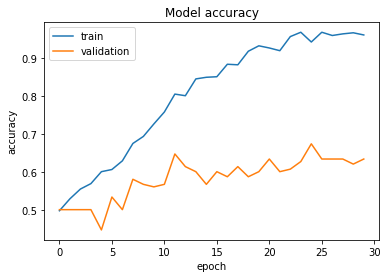

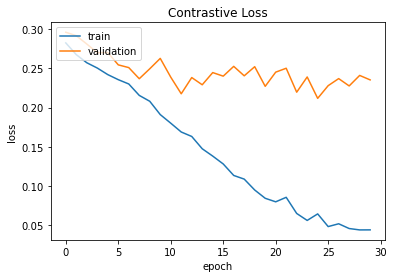

In [336]:
def plt_metric(history, metric, title, has_valid=True):
  
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")